In [ ]:
!wget https://machinehack-be.s3.amazonaws.com/melanoma_tumor_size_prediction_weekend_hackathon_15/Participants_Data_melanoma.zip

--2020-08-09 19:49:09--  https://machinehack-be.s3.amazonaws.com/melanoma_tumor_size_prediction_weekend_hackathon_15/Participants_Data_melanoma.zip
Resolving machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)... 52.219.64.112
Connecting to machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)|52.219.64.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1954982 (1.9M) [application/zip]
Saving to: ‘Participants_Data_melanoma.zip’

Participants_Data_m 100%[===================>]   1.86M  1.07MB/s    in 1.7s    

2020-08-09 19:49:12 (1.07 MB/s) - ‘Participants_Data_melanoma.zip’ saved [1954982/1954982]



In [ ]:
!unzip Participants_Data_melanoma.zip

Archive:  Participants_Data_melanoma.zip
  inflating: sample_submission.csv   
  inflating: __MACOSX/._sample_submission.csv  
  inflating: Test.csv                
  inflating: __MACOSX/._Test.csv     
  inflating: Train.csv               
  inflating: __MACOSX/._Train.csv    


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [ ]:
train.head(5)

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio,tumor_size
0,6930.90,2919.02,0.42116,51.8298,9.888294e+05,109.487,2758.76,72,39.3620,14.103
1,15635.70,4879.36,0.31206,223.5500,2.058426e+06,248.881,5952.53,240,22.0253,2.648
2,10376.20,2613.88,0.25191,127.3370,1.434676e+06,160.093,4635.26,73,29.9963,1.688
3,13093.80,4510.06,0.34444,155.4400,1.812195e+06,173.015,5273.87,32,28.1354,3.796
4,7545.21,2882.36,0.38201,85.1237,1.043918e+06,124.414,3263.35,57,35.0200,18.023


In [ ]:
test.head(5)

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio
0,4946.44,914.06,0.18479,54.5566,6.628345e+05,67.0525,2301.76,22,41.9554
1,5613.85,1629.12,0.29019,51.5524,7.842271e+05,80.1986,3235.00,48,40.7410
2,12421.10,3062.41,0.24654,154.1560,1.763575e+06,186.8590,4684.63,63,29.4778
3,6830.77,2457.66,0.35979,56.8995,9.296623e+05,92.7361,3211.93,42,38.5027
4,33407.80,12353.60,0.36978,219.0740,4.595871e+06,493.3370,13389.36,187,26.8449


In [ ]:
train.isnull().sum(),test.isnull().sum(),train.shape,test.shape,train.dtypes

(mass_npea         0
 size_npear        0
 malign_ratio      0
 damage_size       0
 exposed_area      0
 std_dev_malign    0
 err_malign        0
 malign_penalty    0
 damage_ratio      0
 tumor_size        0
 dtype: int64, mass_npea         0
 size_npear        0
 malign_ratio      0
 damage_size       0
 exposed_area      0
 std_dev_malign    0
 err_malign        0
 malign_penalty    0
 damage_ratio      0
 dtype: int64, (9146, 10), (36584, 9), mass_npea         float64
 size_npear        float64
 malign_ratio      float64
 damage_size       float64
 exposed_area      float64
 std_dev_malign    float64
 err_malign        float64
 malign_penalty      int64
 damage_ratio      float64
 tumor_size        float64
 dtype: object)

In [ ]:
df=train.append(test,ignore_index=True)

In [ ]:
#final ex
df['exposed_area']=df['exposed_area']/max(df['exposed_area'])
df['Ag_x']=df['err_malign']-(df['damage_size']*10)
df['Ag_y']=df['std_dev_malign']-(df['damage_ratio']+df['damage_size'])
df['Ag_z']=df['err_malign']/((df['malign_ratio']*1000)+(df['damage_ratio']*10))
df['Ag_c']=(df['damage_size']*df['damage_ratio'])/100
df['mu']=(df['damage_size']+df['malign_penalty']+df['damage_ratio'])/df['std_dev_malign']

In [ ]:
train = df[df['tumor_size'].isnull()==False]
test = df[df['tumor_size'].isnull()==True]
del test['tumor_size']

In [ ]:
train_df=train.copy()
test_df=test.copy()

In [ ]:
X = train_df.drop(labels=['tumor_size'], axis=1)
y = train_df['tumor_size'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.10, random_state=42)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((8231, 14), (8231,), (915, 14), (915,))

In [ ]:
from math import sqrt 
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [ ]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.02, 
         'num_iterations': 2000,
         'num_leaves': 200,
         'max_depth': -1,
         'min_data_in_leaf': 11,
         'bagging_fraction': 0.90,
         'bagging_freq': 2,
         'bagging_seed': 3,
         'feature_fraction': 0.90,
         'feature_fraction_seed': 2,
         'early_stopping_round': 200,
         'max_bin': 1000
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_cv)
print('RMSLE:', sqrt(mean_squared_error(y_cv,y_pred_lgbm)))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 4.0488
[200]	valid_0's rmse: 3.8444
[300]	valid_0's rmse: 3.79505
[400]	valid_0's rmse: 3.77437
[500]	valid_0's rmse: 3.76757
[600]	valid_0's rmse: 3.76317
[700]	valid_0's rmse: 3.76059
[800]	valid_0's rmse: 3.75861
[900]	valid_0's rmse: 3.76143
[1000]	valid_0's rmse: 3.76202
Early stopping, best iteration is:
[803]	valid_0's rmse: 3.758
RMSLE: 3.7580049326206564


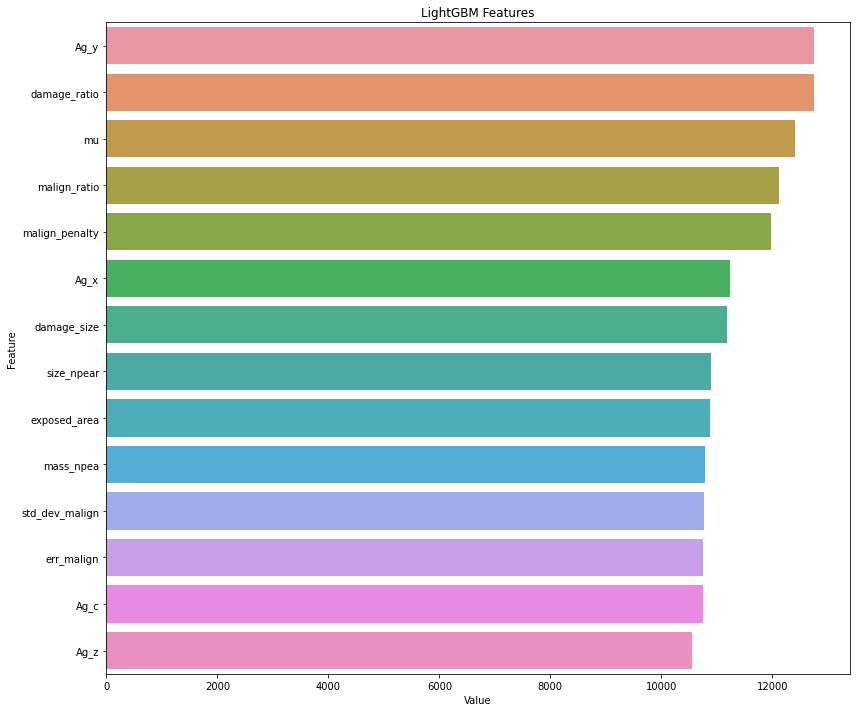

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
Xtest = test_df

In [ ]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm = LGBMRegressor(**param)
    #lgbm = LGBMRegressor(boosting='gbdt',learning_rate=0.1, n_estimators=5000, random_state=101, subsample=0.9)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_error(y_test, y_pred_lgbm)))

    errlgb.append(sqrt(mean_squared_error(y_test,y_pred_lgbm)))
    p = lgbm.predict(Xtest)
    y_pred_totlgb.append(p)

RMSLE LGBM:  3.7677057444755717
RMSLE LGBM:  4.000801873042542
RMSLE LGBM:  4.002929586232914
RMSLE LGBM:  3.9583401314829807
RMSLE LGBM:  3.954373625629737
RMSLE LGBM:  3.9904608246276565
RMSLE LGBM:  4.028965159394608
RMSLE LGBM:  4.008364597579273
RMSLE LGBM:  4.102916867684044
RMSLE LGBM:  4.132798758883214


In [ ]:
np.mean(errlgb,0)

3.9947657169032538

In [ ]:
lgbm_final = np.mean(y_pred_totlgb,0)
lgbm_final

array([ 6.98442274,  9.51260662,  2.40705674, ...,  4.35393707,
       11.15283679,  1.04913569])

In [ ]:
submission = pd.DataFrame({
        "tumor_size":abs(lgbm_final)*1.035
    })
submission.to_csv('./MHd7.csv', index=False)
print(submission)

       tumor_size
0        7.228878
1        9.845548
2        2.491304
3        9.475358
4        7.353392
...           ...
36579    2.781985
36580   14.943995
36581    4.506325
36582   11.543186
36583    1.085855

[36584 rows x 1 columns]


In [ ]:
from google.colab import files
files.download('MHd7.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>